# Загрузка датасета

In [ ]:
# все исправленные датасеты лежать по ссылке https://disk.yandex.ru/d/mEak3w2wbQO3Aw. Для данного ноутбука нужен архив train_face.zip

In [ ]:
!unzip train_face.zip

# Импорт библиотек и установка yolov5

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r /content/yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 11825, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 11825 (delta 8), reused 1 (delta 0), pack-reused 11800
Receiving objects: 100% (11825/11825), 12.37 MiB | 20.34 MiB/s, done.
Resolving deltas: 100% (8120/8120), done.


In [4]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
from PIL import Image
import numpy as np
import shutil
import yaml
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import albumentations

# Предпроцессинг

In [5]:
#функция выполняющая tiling

def tiler(img, labels, img_name, path_to_save_img, path_to_save_label, false_path, slice_size):
  height = img.shape[0]
  width = img.shape[1]
  # labels = pd.read_csv(labels_name, sep=' ', names=['class', 'x', 'y', 'w', 'h'])

  labels[['x', 'w']] = labels[['x', 'w']] * width
  labels[['y', 'h']] = labels[['y', 'h']] * height

  boxes = []

  for row in labels.iterrows():
     x1 = row[1]['x'] - row[1]['w']/2
     y1 = (height - row[1]['y']) - row[1]['h']/2
     x2 = row[1]['x'] + row[1]['w']/2
     y2 = (height - row[1]['y']) + row[1]['h']/2
     
     boxes.append((int(row[1]['class']), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))

  for i in range((height // slice_size)):
    for j in range((width // slice_size)):
      x1 = j * slice_size
      y1 = height - (i * slice_size)
      x2 = ((j + 1) * slice_size) - 1
      y2 = (height - (i + 1)*slice_size) + 1

      pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
      imsaved = False
      slice_labels = []

      for box in boxes:
        if pol.intersects(box[1]):
          inter = pol.intersection(box[1])

          if not imsaved:
              sliced = img[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
              cv2.imwrite(os.path.join(path_to_save_img, f'_{i}_{j}_{img_name}'), sliced)
              # sliced_im = Image.fromarray(sliced)
              # sliced_im.save(os.path.join(path_to_save_img, f'_{i}_{j}_{img_name}'))
              
              # print(f'_{i}_{j}_{img_name}')
              # plt.imshow(sliced)
              # yield 'fuck'
              imsaved = True

          new_box = inter.envelope
          center = new_box.centroid
          x, y = new_box.exterior.coords.xy

          new_width = (max(x) - min(x)) / slice_size
          new_height = (max(y) - min(y)) / slice_size

          new_x = (center.coords.xy[0][0] - x1) / slice_size
          new_y = (y1 - center.coords.xy[1][0]) / slice_size

          slice_labels.append([box[0], new_x, new_y, new_width, new_height])

      if len(slice_labels) > 0:
          slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
          slice_df.to_csv(os.path.join(path_to_save_label, f'_{i}_{j}_{img_name.split(".")[0]}.txt'), sep=' ', index=False, header=False, float_format='%.6f')

      if not imsaved and falsepath:
          sliced = img[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
          cv2.imwrite(os.path.join(falsepath, f'_{i}_{j}_{img_name}'), sliced)
          imsaved = True

In [6]:
# функция для применения albumentations с учетом bounding box'ов

def resize_using_albumentations(img_arr, bboxes, h, w):
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'x_max', 'y_max', "class_id"]}
    """
    # create resize transform pipeline

    height, width, _  = img_arr.shape

    transform = albumentations.Compose(
        [albumentations.PadIfNeeded(min_height=max(height, width), min_width=max(height, width), always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
         albumentations.Resize(height=h, width=w, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='yolo'))

    transformed = transform(image=img_arr, bboxes=bboxes)

    return transformed

In [7]:
# фунция для предпроцессинга данных

def preprocessing(img_path, label_path, falsepath):
    img_name = img_path.split('/')[-1]
    img = cv2.imread(img_path)
    labels = pd.read_csv(label_path, sep=' ', names=['class', 'x', 'y', 'w', 'h'])

    h, w, _ = img.shape

    # применение CLAHE
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(20,20))
    lab_img[:, :, 0] = clahe.apply(lab_img[:, :, 0])
    img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

    transformed = resize_using_albumentations(img, labels[['x', 'y', 'w', 'h', 'class']].to_numpy(), 2500, 2500)
    img = transformed['image']
    bboxes = transformed['bboxes']

    labels = pd.DataFrame(data=bboxes, columns=['x', 'y', 'w', 'h', 'class'])
    labels = labels[['class', 'x', 'y', 'w', 'h']]

    tiler(img, labels, img_name, '/content/train/images_tiled', '/content/train/labels_tiled', falsepath, 500)

In [8]:
!rm -r /content/train/images_tiled
!rm -r /content/train/labels_tiled

!mkdir /content/train/images_tiled
!mkdir /content/train/labels_tiled

!rm -r /content/falseFolder
!mkdir /content/falseFolder

rm: cannot remove '/content/train/images_tiled': No such file or directory
rm: cannot remove '/content/train/labels_tiled': No such file or directory


In [10]:
images_folder = '/content/train/images/'
labels_folder = '/content/train/labels/'
falsepath = '/content/falseFolder'

for name in os.listdir(images_folder):
  preprocessing(images_folder + name,  labels_folder + f'{name.split(".")[0]}.txt', falsepath)

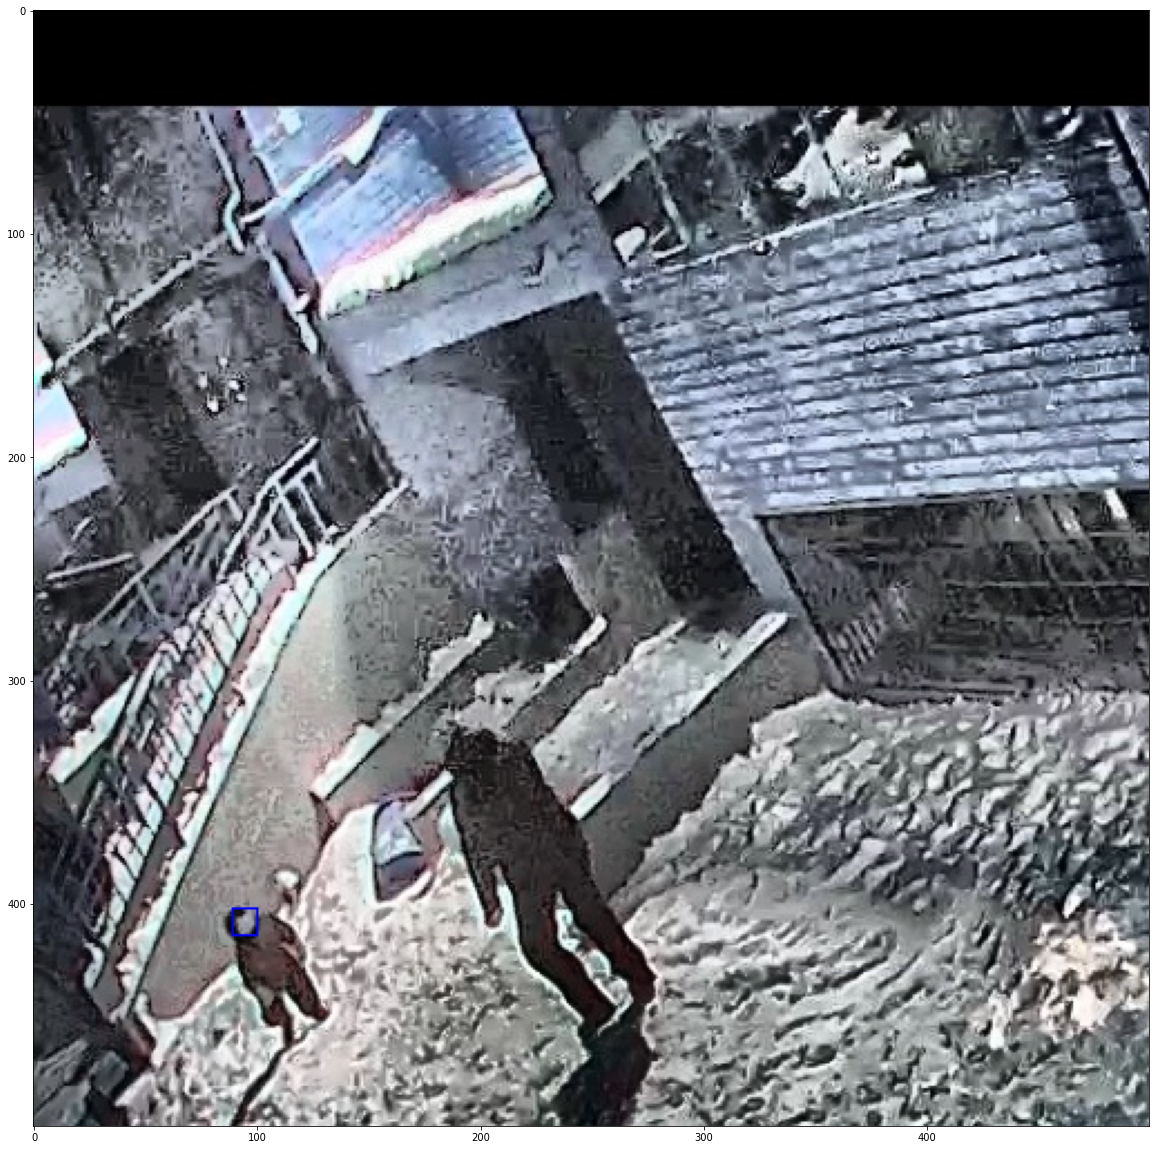

In [11]:
name = '_1_0_23-11-2021_02-38-01_PM'
img = cv2.imread(f'/content/train/images_tiled/{name}.jpg')
df = pd.read_csv(f'/content/train/labels_tiled/{name}.txt', sep=' ', names=['class', 'x', 'y', 'w', 'h'])
df

dh, dw, _ = img.shape
x, y, w, h = df['x'], df['y'], df['w'], df['h']

l = int((x - w / 2) * dw)
r = int((x + w / 2) * dw)
t = int((y - h / 2) * dh)
b = int((y + h / 2) * dh)

if l < 0:
    l = 0
if r > dw - 1:
    r = dw - 1
if t < 0:
    t = 0
if b > dh - 1:
    b = dh - 1


cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.figure(figsize=(20, 30))
plt.imshow(img)

# Разделение на обучающую и валидационную выборки

In [46]:
!rm -r /content/train_split
!rm -r /content/val_split

!mkdir /content/train_split
!mkdir /content/train_split/images
!mkdir /content/train_split/labels
!mkdir /content/val_split
!mkdir /content/val_split/images
!mkdir /content/val_split/labels

In [47]:
train_path = '/content/train_split/'
val_path = '/content/val_split/'
source_path = '/content/train/'

names = [s.split('.')[0] for s in os.listdir('/content/train/images_tiled')]
train_names, val_names = train_test_split(names, test_size=0.2, random_state=42, shuffle=True)
print(len(train_names), len(val_names))

for name in train_names:
  shutil.copy(os.path.join(os.path.join(source_path, 'images_tiled'), f'{name}.jpg'), os.path.join(train_path, 'images'))
  shutil.copy(os.path.join(os.path.join(source_path, 'labels_tiled'), f'{name}.txt'), os.path.join(train_path, 'labels'))

for name in val_names:
  shutil.copy(os.path.join(os.path.join(source_path, 'images_tiled'), f'{name}.jpg'), os.path.join(val_path, 'images'))
  shutil.copy(os.path.join(os.path.join(source_path, 'labels_tiled'), f'{name}.txt'), os.path.join(val_path, 'labels'))


print(len(os.listdir(train_path + 'images')), len(os.listdir(val_path + 'images')))

495 267
495 267


# Создание data.yaml и объявление конфигурации модели

In [48]:
num_classes = 1
#в папке data_for_yolo создадим dataset.yaml со следующим содержимым

yaml_content = """
train: /content/train_split/images
val: /content/val_split/images

# number of classes
nc: 1

# class names
names: ['face']
"""

names = yaml.safe_load(yaml_content)

with open('/content/data.yaml', 'w') as file:
    yaml.dump(names, file)

In [49]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [51]:
!cat /content/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [52]:
%%writetemplate /content/yolov5/models/custom_yolov5m.yaml
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Обучение yolov5m

In [53]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
!python /content/yolov5/train.py --img 500 --batch 64 --epochs 250 --data /content/data.yaml --cfg /content/yolov5/models/custom_yolov5m.yaml --weights yolov5m.pt --name yolov5m_results  --cache

train: weights=yolov5m.pt, cfg=/content/yolov5/models/custom_yolov5m.yaml, data=/content/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=250, batch_size=64, imgsz=500, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5m_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-18-geb359c3 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, 

# Инференс

In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/789899/test_dataset_test.zip

In [ ]:
!unzip test_dataset_test.zip

In [57]:
!rm -r /content/test/images_tiled
!mkdir /content/test/images_tiled

!rm -r /content/test/images_filled
!mkdir /content/test/images_filled

In [60]:
test_path = '/content/test/images'
path_to_save_img = '/content/test/images_tiled'
slice_size = 500

for name in os.listdir(test_path):
    img = cv2.imread(os.path.join(test_path, name))
    height, width, _ = img.shape

    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(20,20))
    lab_img[:, :, 0] = clahe.apply(lab_img[:, :, 0])
    img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)

    transform = albumentations.Compose(
        [albumentations.PadIfNeeded(min_height=max(height, width), min_width=max(height, width), always_apply=True, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
         albumentations.Resize(height=2500, width=2500, always_apply=True)]) #albumentations.Resize(height=2000, width=2000, always_apply=True)
    
    img = transform(image=img)['image']
    cv2.imwrite('/content/test/images_filled/' + name, img)

    height, width, _ = img.shape
    
    for i in range((height // slice_size)):
        for j in range((width // slice_size)):
          x1 = j * slice_size
          y1 = height - (i * slice_size)
          x2 = ((j + 1) * slice_size) - 1
          y2 = (height - (i + 1)*slice_size) + 1

          sliced = img[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]

          if sliced.sum() != 0:
              cv2.imwrite(os.path.join(path_to_save_img, f'_{i}_{j}_{name}'), sliced)

In [ ]:
!python3 yolov5/detect.py --weights /content/yolov5/runs/train/yolov5m_results/weights/best.pt --img 500 --conf 0.65 --source /content/test/images_tiled --save-txt --save-conf

In [62]:
def get_test_labels_df(path_to_txt_folder):
  simple_solution = []
  for detection_file in os.listdir(path_to_txt_folder):
    img_name = detection_file.split('.')[0] + '.jpg'
    true_img_name = '_'.join(img_name.split('_')[3:])
    filled_img = cv2.imread('/content/test/images_filled/' + true_img_name)
    h, w, _ = cv2.imread('/content/test/images/' + true_img_name).shape
    i, j = int(img_name.split('_')[1]), int(img_name.split('_')[2])

    diff_h_top = 0
    diff_v_top = 0
    
    if h < w:
      diff_v_top = 0
      
      for k in range(2500):
        if filled_img[k].sum() < 1000:
          diff_v_top += 1
        else:
          break

    elif h > w:
      diff_h_top = 0

      for n in range(2500):
        if filled_img[:, n].sum() < 1000:
          diff_h_top += 1
        else:
          break

    coef = max(h, w) / 2500

    with open(path_to_txt_folder + detection_file, 'r') as f:
      data = f.read()
      data = [i for i in data.split('\n') if i != '']
    for line in data:
      val = [float(i) for i in line.split()]
      _, xywh, conf = val[0], val[1:5], val[5]
      center_x, center_y, width, height = xywh
      xmin = (((center_x - (width / 2)) * slice_size + slice_size * j - diff_h_top) * coef) / w
      xmax = (((center_x + (width / 2)) * slice_size + slice_size * j - diff_h_top) * coef) / w
      ymin = (((center_y - (height / 2)) * slice_size + slice_size * i - diff_v_top) * coef) / h
      ymax = (((center_y + (height / 2)) * slice_size + slice_size * i - diff_v_top) * coef) / h
      simple_solution.append([true_img_name, 2, conf, xmin, xmax, ymin, ymax])
  return simple_solution

In [63]:
df = pd.DataFrame(get_test_labels_df('/content/yolov5/runs/detect/exp/labels/'), columns=['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax'])

In [65]:
df

ImageID  LabelName      Conf    XMin    XMax  \
0    0_25-11-2021_03-41-21_PM.jpg          2  0.729677  0.7012  0.7120   
1      24-11-2021_04-53-50_AM.jpg          2  0.748818  0.9104  0.9140   
2      25-11-2021_09-09-37_AM.jpg          2  0.820380  0.2324  0.2368   
3      26-11-2021_11-42-01_AM.jpg          2  0.830082  0.6720  0.6828   
4      26-11-2021_11-42-01_AM.jpg          2  0.925636  0.6716  0.6852   
..                            ...        ...       ...     ...     ...   
371    25-11-2021_07-03-10_AM.jpg          2  0.672014  0.8348  0.8380   
372    26-11-2021_08-41-58_AM.jpg          2  0.684513  0.4004  0.4068   
373    26-11-2021_11-44-35_AM.jpg          2  0.871270  0.1052  0.1100   
374    24-11-2021_03-18-11_PM.jpg          2  0.699434  0.2904  0.2952   
375    24-11-2021_03-07-29_AM.jpg          2  0.818142  0.4424  0.4472   

         YMin      YMax  
0    0.388537  0.398948  
1    0.444444  0.452978  
2    0.101154  0.108935  
3    0.791467  0.813511  
4    0.888178  0.917333  
..        ...       ...  
371  0.229187  0.238383  
372  0.904533  0.911467  
373  0.336000  0.345196  
374  0.421592  0.431495  
375  0.194526  0.205844  

[376 rows x 7 columns]

In [66]:
df.to_csv("faces_only_solution.csv", sep=';', index=False)

# Отображение предсказаний

(1520, 2688, 3)
[['2' '0.699434' '0.2904' '0.29519999999999996' '0.4215915789473684'
  '0.4314947368421052']]


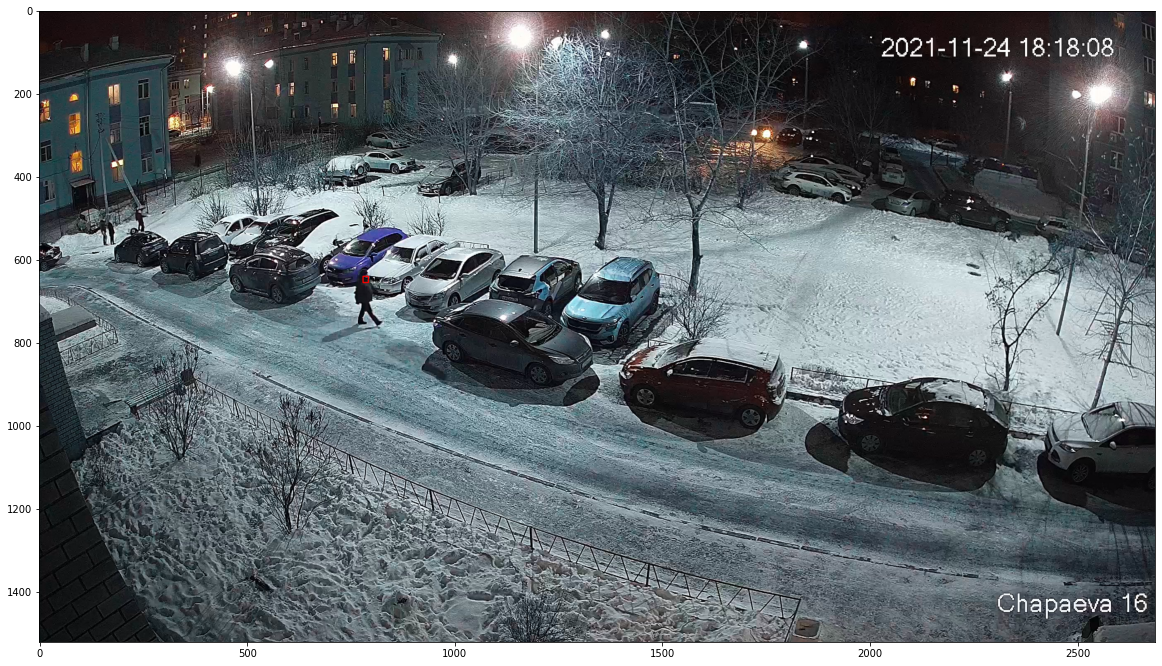

In [69]:
img_name = '24-11-2021_03-18-11_PM.jpg'
img = cv2.imread(f'/content/test/images/{img_name}')
ndf = pd.read_csv('faces_only_solution_the_last.csv', sep=';', names=['class', 'conf', 'x', 'y', 'w', 'h'])
data = ndf.loc[img_name].to_numpy()
print(img.shape)
if list(ndf.index).count(img_name) == 1:
  data = np.expand_dims(data, axis=0)
print(data)

dh, dw, _ = img.shape

for p in range(len(data)):
    x, y, w, h = float(data[p][2]), float(data[p][3]), float(data[p][4]), float(data[p][5])

    l = int(x * dw)
    r = int(y * dw)
    t = int(w * dh)
    b = int(h * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1


    cv2.rectangle(img, (l, t), (r, b), (255, 0, 0), 2)

plt.figure(figsize=(20, 30))
plt.imshow(img)